# **Final Project for Numerical Analysis**

----

## *Applications of Gaussian Quadrature on Polynomial and Non-Polynomial Functions*

*Note: The book used for this class was "Numerical Analysis: The Mathematics of Scientific Computing, Kincaid and Cheney, 3rd edition". Any references to "the book" refer to this book.*

Part One: Defining glaser_liu_rokhlin(), which we will refer to as $GLR()$, an algorithm which computes Gaussian Quadrature Formulas for function of $degree$ $n$ is $\Theta(n)$ time. 

While $GLR()$, based on a [paper](https://apps.dtic.mil/dtic/tr/fulltext/u2/a635869.pdf) by Andreas Glaser, Xiangtao Liu, and Vladimir Rokhlin, can work with various families of orthogonal polynomials, for our purposes we modified it to work specifically for Legendre polynomials, thereby allowing us to cut out some of the code used to generalize the algorithm and make it work more efficiently for the Legendre polynomials.

### Warning! This notebook is not meant to teach someone without any background the subject of Gaussian Quadrature. It is merely a demonstration for those already involved in the subject who want to see how they can use it hands on. Proceed with caution!

In [2]:
using Polynomials, SpecialPolynomials, MTH229, Plots

function newton(p, x0)
    maxsteps = 25
    dp  = derivative(p)
    while maxsteps > 0
        px, dpx = p(x0),  dp(x0) #orthogonal_polyval_derivative(p, x0)
        Δ = px/dpx
        isnan(Δ) && return (x0, dpx)
        if isinf(Δ)
            x0 += sqrt(eps())  # give a nudge from minimum or maximum
            continue
        end
        x0 -= Δ
        min(abs(Δ),abs(px)) <= sqrt(eps())/100 && return  x0, dp(x0)# orthogonal_polyval_derivative(p, x0)[2]
        maxsteps -= 1
    end
    @warn "Newton's method did not converge from $x0"
    NaN
end
function RK(t0,  x0, F, h, n)
    k0 = h*F(t0,x0)
    local x1
    for i in 1:n
        t1 = t0 + h
        k1 = h * F(t0+h,x0+k0)
        x1 = x0 + 1/2 * (k0+k1)
        t0, x0, k0 = t1, x1, k1
    end
    x1
end

function prufer(π)
    n = Polynomials.degree(π)
    Π = typeof(π)
    (θ, x) -> begin
        dom = domain(Π)
        a,b,c,d, e = SpecialPolynomials.abcde(Π)
        p =  a*x^2 + b*x  +  c
        dp = 2a*x + b
        q = d*x +  e
        dq = d
        r  = -(a*n*(n-1)  + d*n)
        dr = 0
        -inv(sqrt(r/p) + (dr*p - dp*r + 2r*q)/(2r*p) * sin(2θ)/2)
    end
end


function glaser_liu_rokhlin_gauss_nodes(π, x0=0;
                                        m=10)
    symmetry = true
    n = Polynomials.degree(π)
    F = prufer(π)
    x = float(x0)

    # step 1 to get initial might be newton or might be RK
    if symmetry && iseven(n)
        # a max at π(x0)
        x = RK(pi/2, x0, F, -(pi/2)/m, m)
    end
    
    x1, dπ1 = newton(π, x)
    rts, dπrts = [x1], [dπ1]
    N = symmetry ? div(n+1,2) : n
    for i in 2:N
        xx = RK(pi/2, rts[end], F, -pi/m, m)
        x, dπx = newton(π, xx)
        push!(rts, x)
        push!(dπrts, dπx)
    end
    if symmetry
        if iseven(n)
            rts = vcat(-reverse(rts), rts)
            dπrts = vcat(-reverse(dπrts), dπrts)
        else
            rts = vcat(-reverse(rts[2:end]), rts)
            dπrts = vcat(-reverse(dπrts[2:end]), dπrts)            
        end
    end
    # get weights 
    weights = @. (1 * 2)/(1-(rts)^2)/((Polynomials.derivative(π)(rts))^2)
    rts,  weights
end

#a1, a2 = glaser_liu_rokhlin_gauss_nodes(basis(Legendre, 6))
#@show a1, a2
#plot(a1, a2)
# x = variable()
# xs = range(-pi/2, pi/2, length = 200)
# ys =x.(xs)
# plot(xs, (ys))

glaser_liu_rokhlin_gauss_nodes (generic function with 2 methods)

### Demonstrating 7.3: Theorem 1
#### In Chapter 7.3 of the book, we see the following theorem:
*Let w be a positive weight frunction and let q be a nonzero polynomial of degree $n+1$ that is w-* **orthogonal** *to $\Pi_{n}$ in the sense that for any p in $\Pi_{n}$, we have</br>*  $\int\limits_a^b{q(x)p(x)w(x)dx}$ = 0
    *If* $x_{0},x_{1}, ... ,x_{n}$ *are the zeros of q, then the quadrature formula,* $\int\limits_a^b{f(x)w(x)dx}$ $\approx$ $\sum_{i=0}^{n}A_i f(x_i)$*, with coefficients given by*  $A_i = \int\limits_a^b{w(x) \Pi_{j=0}^{n}\frac{x-x_j}{x_i-x_j}dx}$ will be exact for all ${f ∈\Pi_{2n+1}}$ 

Using a for-loop we can see that the nodes and weights vectors from $GLR()$ to effectively approximate integrals, with better than $1.0*10^{10}$ precision, for polynomials of degree $i$  such that $0 \leq i<2n$. This is demonstrated below:

In [5]:
n = 10
xs, ws = glaser_liu_rokhlin_gauss_nodes(basis(Legendre, n))
for i in n:2n
    p = basis(Legendre, i)
    q = Polynomials.integrate(p, -1, 1)
    qq = sum(p(x)*w for (x,w) in zip(xs, ws))
    @show i, q, qq, q-qq
end

(i, q, qq, q - qq) = (10, 1.2545520178264269e-14, 5.117341355252152e-17, 1.2494346764711747e-14)
(i, q, qq, q - qq) = (11, 0.0, 2.6020852139652106e-18, -2.6020852139652106e-18)
(i, q, qq, q - qq) = (12, -3.019806626980426e-14, 5.204170427930421e-18, -3.020327044023219e-14)
(i, q, qq, q - qq) = (13, 0.0, 0.0, 0.0)
(i, q, qq, q - qq) = (14, -5.969669203409467e-13, -3.469446951953614e-18, -5.969634508939947e-13)
(i, q, qq, q - qq) = (15, 0.0, 0.0, 0.0)
(i, q, qq, q - qq) = (16, -3.552713678800501e-15, 2.7755575615628914e-16, -3.83026943495679e-15)
(i, q, qq, q - qq) = (17, 0.0, -6.938893903907228e-18, 6.938893903907228e-18)
(i, q, qq, q - qq) = (18, 1.8189894035458565e-12, 1.8735013540549517e-16, 1.818802053410451e-12)
(i, q, qq, q - qq) = (19, 0.0, -1.3877787807814457e-17, 1.3877787807814457e-17)
(i, q, qq, q - qq) = (20, -5.831785054866145e-11, -0.3846001356520965, 0.38460013559377865)


### Efficacy of GLR() on Non-Polynomial Functions

Observe $GLR()$ on $f(x)=e^x$. Notice how we get accuracy to 12 decimal places using only 6 points!

In [9]:
f(x) = exp(x)
MTH229.integrate(f, -1, 1)
@show a = f(1)-f(-1)
for i in 1:12
    xs, ws = glaser_liu_rokhlin_gauss_nodes(basis(Legendre, i))
    @show i, sum(f(x)*w for (x,w) in zip(xs, ws)) - a
end

a = f(1) - f(-1) = 2.3504023872876028
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (1, -0.35040238728760276)
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (2, -0.007706299377872483)
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (3, -6.545860759210598e-5)
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (4, -2.9513122612456755e-7)
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (5, -8.247775795666712e-10)
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (6, -1.568078999980571e-12)
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (7, -1.7763568394002505e-15)
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (8, 4.440892098500626e-16)
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (9, 1.3322676295501878e-15)
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (10, 0.0)
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (11, 1.7763568394002505e-15)
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (12, 8.881784197001252e-16)


Using a calculator, we can easily find $\int\limits_{-1}^1{cos(x)dx}$ $\approx 1.682941969615793 $. But here we find that same result without integrating! And we use only 12 points!

In [14]:
f(x) = cos(x)
a = f(1)-f(-1)
for i in 1:12
    xs, ws = glaser_liu_rokhlin_gauss_nodes(basis(Legendre, i))
    q = sum(f(x)*w for (x,w) in zip(xs, ws))
    @show i, q, q - a
end

(i, q, q - a) = (1, 2.0, 2.0)
(i, q, q - a) = (2, 1.675823655389986, 1.675823655389986)
(i, q, q - a) = (3, 1.6830035477269165, 1.6830035477269165)
(i, q, q - a) = (4, 1.6829416886959734, 1.6829416886959734)
(i, q, q - a) = (5, 1.682941970407192, 1.682941970407192)
(i, q, q - a) = (6, 1.6829419696142796, 1.6829419696142796)
(i, q, q - a) = (7, 1.6829419696157952, 1.6829419696157952)
(i, q, q - a) = (8, 1.6829419696157928, 1.6829419696157928)
(i, q, q - a) = (9, 1.6829419696157937, 1.6829419696157937)
(i, q, q - a) = (10, 1.6829419696157928, 1.6829419696157928)
(i, q, q - a) = (11, 1.682941969615794, 1.682941969615794)
(i, q, q - a) = (12, 1.682941969615793, 1.682941969615793)


Using a calculator, we can easily find $\int\limits_{-1}^1{cos(x)^2+sin(x) dx}$ comes out to $\approx{1.454648713412841}$. But here we find that same result without integrating! And we used only 8 points!

In [20]:
f(x) = cos(x)^2 + sin(x)
a = f(1)-f(-1)
for i in 1:15
    xs, ws = glaser_liu_rokhlin_gauss_nodes(basis(Legendre, i))
    q = sum(f(x)*w for (x,w) in zip(xs, ws))
    @show i, q, q - a
end

(i, q, q - a) = (1, 2.0, 0.317058030384207)
(i, q, q - a) = (2, 1.404192461982327, -0.27874950763346606)
(i, q, q - a) = (3, 1.4564451711321824, -0.2264967984836106)
(i, q, q - a) = (4, 1.4546153354356182, -0.22832663418017485)
(i, q, q - a) = (5, 1.454649094168245, -0.22829287544754795)
(i, q, q - a) = (6, 1.4546487104739119, -0.22829325914188114)
(i, q, q - a) = (7, 1.4546487134292159, -0.22829325618657714)
(i, q, q - a) = (8, 1.454648713412772, -0.2282932562030211)
(i, q, q - a) = (9, 1.4546487134128414, -0.2282932562029516)
(i, q, q - a) = (10, 1.4546487134128407, -0.22829325620295227)
(i, q, q - a) = (11, 1.4546487134128419, -0.22829325620295116)
(i, q, q - a) = (12, 1.4546487134128407, -0.22829325620295227)
(i, q, q - a) = (13, 1.4546487134128405, -0.2282932562029525)
(i, q, q - a) = (14, 1.45464871341284, -0.22829325620295293)
(i, q, q - a) = (15, 1.4546487134128407, -0.22829325620295227)


Now, if we put some asymptotes at $x = -1, 1$, then we see that $GLR()$, using using a Legendre basis, won't get us anywhere, as the behavior of $Legendre(n)$ polynomials is such that as we get closer to $-1$ and $1$ we get more and more roots as n gets bigger, this makes it impossible to choose our points "wisely". We find such behavior on the graph of $f(x)=\sqrt{1/(1-x^2)}$. Below can see that $\displaystyle{\lim_{x \to -1,  1}} f(x) = \infty $:



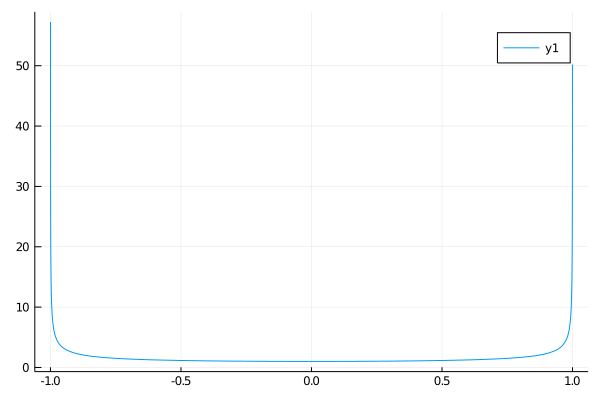

In [18]:
f(x)=1/ sqrt(1-x^2)
plot(f, -1,1)

Sure enough, if we try using $GLR()$ with a Legendre basis $f(x)=\sqrt{1/(1-x^2)}$ it takes more than 1000 points to get $1.0*10^{-3}$ precision... not very efficient

In [37]:
f(x) = 1/ sqrt(1-x^2)
bound = 1/3+1/3+1/3.1
MTH229.integrate(f, -bound, bound)
@show a = f(bound)-f(-bound)
n = 1090
for i in n:n+5
    xs, ws = glaser_liu_rokhlin_gauss_nodes(basis(Legendre, i))
    @show i, sum(f(x)*w for (x,w) in zip(xs, ws)) - a
end

a = f(bound) - f(-bound) = 0.0
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (1090, 3.1399957895773873)
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (1091, 3.139997252576781)
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (1092, 3.139998712898014)
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (1093, 3.1400001705483676)
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (1094, 3.1400016255350676)
(i, sum((f(x) * w for (x, w) = zip(xs, ws))) - a) = (1095, 3.1400030778653356)


$Note_{Turns out that we can use $GLR()$ with a Chebyshev basis to help us find the roots on the above function in a more reasonable amount of time, but we that we shall leave for a different time.}$

Gaussian Quadrature turns out to be a quite nifty tool in approximating non-polynomial functions

This concludes our lesson on Gaussian Quadrature